In [1]:
import os
import shutil
import random

# Paths to original dataset
dataset_path = r"C:\Users\Prathamesh\Downloads\TB Dataset\TB_Chest_Radiography_Database"
categories = ["Normal", "Tuberculosis"]

# Create new directories
split_base = "path_to_split_data"
os.makedirs(os.path.join(split_base, "train/Normal"), exist_ok=True)
os.makedirs(os.path.join(split_base, "train/Tuberculosis"), exist_ok=True)
os.makedirs(os.path.join(split_base, "val/Normal"), exist_ok=True)
os.makedirs(os.path.join(split_base, "val/Tuberculosis"), exist_ok=True)
os.makedirs(os.path.join(split_base, "test/Normal"), exist_ok=True)
os.makedirs(os.path.join(split_base, "test/Tuberculosis"), exist_ok=True)

# Splitting the data
for category in categories:
    img_path = os.path.join(dataset_path, category)
    images = os.listdir(img_path)
    random.shuffle(images)

    train_split = int(0.8 * len(images))
    val_split = int(0.9 * len(images))

    for i, img in enumerate(images):
        src = os.path.join(img_path, img)

        if i < train_split:
            dest = os.path.join(split_base, "train", category, img)
        elif i < val_split:
            dest = os.path.join(split_base, "val", category, img)
        else:
            dest = os.path.join(split_base, "test", category, img)

        shutil.copy(src, dest)

print("✅ Dataset successfully split!")

✅ Dataset successfully split!


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
import os

# Dataset Path 
data_dir = r"C:\Users\Prathamesh\Downloads\TB Split Data"

# Data Preprocessing
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    os.path.join(data_dir, "train"),
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

val_data = datagen.flow_from_directory(
    os.path.join(data_dir, "val"),
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

test_data = datagen.flow_from_directory(
    os.path.join(data_dir, "test"),
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

# Load Pre-trained ResNet50 (without top layers)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers (for feature extraction)
for layer in base_model.layers:
    layer.trainable = False

# Add Custom Layers
x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)  # Prevent overfitting
x = Dense(1, activation="sigmoid")(x)  # Binary Classification

# Final Model
model = Model(inputs=base_model.input, outputs=x)

Found 3360 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


In [6]:
#  Compile Model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
)

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 384s 4s/step - accuracy: 0.8376 - loss: 0.4506 - val_accuracy: 0.8333 - val_loss: 0.3385
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 362s 3s/step - accuracy: 0.8258 - loss: 0.4362 - val_accuracy: 0.8333 - val_loss: 0.3240
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step - accuracy: 0.8274 - loss: 0.4158 - val_accuracy: 0.8333 - val_loss: 0.3159
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.8425 - loss: 0.3979 - val_accuracy: 0.8333 - val_loss: 0.3140
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.8302 - loss: 0.4181 - val_accuracy: 0.8333 - val_loss: 0.3240
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 393s 4s/step - accuracy: 0.8358 - loss: 0.4021 - val_accuracy: 0.8333 - val_loss: 0.3424
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 387s 4s/step - accuracy: 0.8338 - loss: 0.4025 - val_accuracy: 0.8333 - val_loss: 0.3093
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.8273 - loss: 0.4060 - val_accu

In [7]:
# Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2%}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 802ms/step - accuracy: 0.8364 - loss: 0.4624
Test Accuracy: 83.33%


In [9]:
from tensorflow.keras.optimizers import Adam

# Unfreeze last 10 layers of ResNet50
for layer in base_model.layers[-10:]:  
    layer.trainable = True

# Apply Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,   
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    horizontal_flip=True,  
    brightness_range=[0.8, 1.2],  
)

# Load Data
train_data = datagen.flow_from_directory(os.path.join(data_dir, "train"), target_size=(224, 224), batch_size=32, class_mode="binary")
val_data = datagen.flow_from_directory(os.path.join(data_dir, "val"), target_size=(224, 224), batch_size=32, class_mode="binary")

# Compile with Lower Learning Rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

# Train for More Epochs
history = model.fit(train_data, validation_data=val_data, epochs=25)

Found 3360 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8331 - loss: 0.5619 - val_accuracy: 0.8333 - val_loss: 0.5876
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.8366 - loss: 0.4371 - val_accuracy: 0.8333 - val_loss: 0.7252
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.8316 - loss: 0.4245 - val_accuracy: 0.8333 - val_loss: 0.4630
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8284 - loss: 0.4070 - val_accuracy: 0.8357 - val_loss: 0.4115
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8428 - loss: 0.3765 - val_accuracy: 0.8333 - val_loss: 0.4055
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8463 - loss: 0.3727 - val_accuracy: 0.8571 - val_loss: 0.4188
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.8430 - loss: 0.3528 - val_accuracy: 0.8738 - val_loss: 0.3731
Epoch 8/25
105

In [10]:
# Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2%}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 651ms/step - accuracy: 0.9341 - loss: 0.1798
Test Accuracy: 94.05%


In [11]:
# Save Model
model.save("TB_Detection_ResNet50.h5")

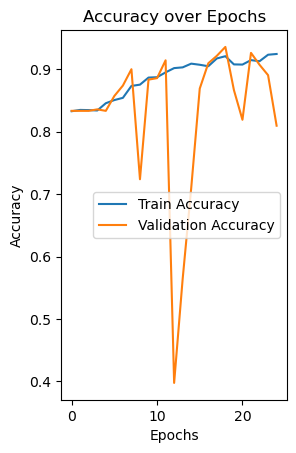

In [17]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

Text(0.5, 1.0, 'Loss over Epochs')

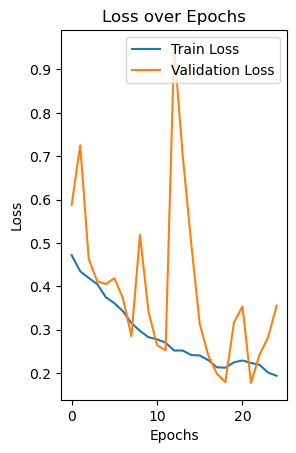

In [18]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

In [1]:
# This is because of inblanced data in train, test and val